In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# ------------------------------------------------------------------------------
#
#   Copyright 2024 Valory AG
#
#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.
#
# ------------------------------------------------------------------------------

"""Script for analyzing market creator markets."""

from collections import defaultdict
from datetime import datetime, timedelta, timezone
from enum import Enum
from mech_request_utils import get_mech_requests, IPFS_ADDRESS
from scipy import stats
from string import Template
from typing import Any, Dict, Optional
from IPython.display import display, HTML

import seaborn as sns
import dateutil.parser
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pytz
import requests

MARKET_CREATOR_ADDRESS = "0x89c5cc945dd550BcFfb72Fe42BfF002429F46Fec"

## Process mech requests
Process mech requests from the Market Creator

In [2]:
mech_requests = get_mech_requests(MARKET_CREATOR_ADDRESS)

          Fetching requests...
           5585 requests found


    Finding duplicate delivers: 100%|██████████| 5585/5585 [00:00<00:00, 1526866.63it/s]


Duplicate deliver ids found: 55


    Finding duplicate delivers: 100%|██████████| 5585/5585 [00:00<00:00, 1920097.36it/s]


Duplicate deliver ids found: 0


        Fetching IPFS contents: 100%|██████████| 18/18 [00:00<00:00, 18.16it/s]


Time of execution: 0:00:14.143137


DescribeResult(nobs=5493, minmax=(0, 42851), mean=95.28090296741307, variance=900835.6368475459, skewness=34.46180239797064, kurtosis=1489.0988046017505)


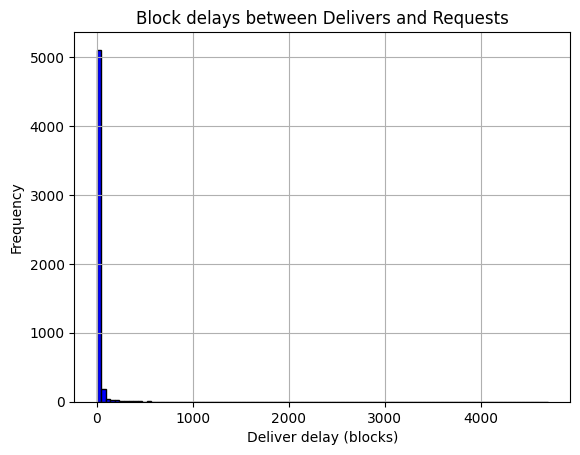

,Request ID,Prompt,Block Timestamp (UTC),Result,Deliver Block Timestamp (UTC)
0,21064806733482770901930093558552145888082617270563214360899869092890655038937,Will the Efficiency Commission proposed by Trump and Elon Musk be officially established by 15 September 2024?,2024-09-16 02:50:35,"{""has_occurred"": false, ""is_determinable"": true, ""is_valid"": true}",2024-09-16 02:51:55
1,4437897716755637321369775590571818531664901238547876534437742235644565156886,Will the trial of the three ex-officers over Tyre Nichols' fatal assault conclude by 15 September 2024?,2024-09-16 02:36:40,"{""has_occurred"": false, ""is_determinable"": true, ""is_valid"": true}",2024-09-16 02:38:15
2,106500807181004094931363291787200301658438996216963052496846373140433106565815,"Will the Greece's new tax on cruise ship arrivals be successfully implemented by September 15, 2024?",2024-09-16 02:23:10,"{""has_occurred"": false, ""is_determinable"": true, ""is_valid"": true}",2024-09-16 02:24:15
3,80111906349490403770150817747482576451522877008857865169965513258822903377236,Will Tom Brady start his NFL broadcasting career on 15 September 2024?,2024-09-16 01:47:55,"{""has_occurred"": false, ""is_determinable"": true, ""is_valid"": true}",2024-09-16 01:49:20
4,48205822738232981613465340996884268569986324477304571860100924039965011479392,Will the Michigan vs. Texas college football game result in a Michigan victory on 15 September 2024?,2024-09-16 01:01:55,"{""has_occurred"": false, ""is_determinable"": true, ""is_valid"": true}",2024-09-16 01:04:15
5,16112679238669083356689018077456933339827871916273099052591098082353023789867,Will Apple launch the iPhone 16 by 15 September 2024?,2024-09-16 00:45:20,"{""has_occurred"": true, ""is_determinable"": true, ""is_valid"": true}",2024-09-16 00:47:05
6,60910169641023741582434620768195873450696003628815004562519732732972204765239,Will England batsman Ben Duckett play against Sri Lanka in the third Test on 15 September 2024?,2024-09-16 00:30:30,"{""has_occurred"": true, ""is_determinable"": true, ""is_valid"": true}",2024-09-16 00:32:15
7,57542521151901601877634863248274724031494312743773250226527491982899857585075,Will Tropical Storm Francine hit Louisiana as a hurricane on 15 September 2024?,2024-09-16 00:16:55,"{""has_occurred"": false, ""is_determinable"": true, ""is_valid"": true}",2024-09-16 00:18:10
8,72569501911006500840295719139848975791549352470191037599138143021942171429927,Will Nanoleaf launch another smart switch on or by 15 September 2024?,2024-09-16 00:02:00,"{""has_occurred"": false, ""is_determinable"": true, ""is_valid"": true}",2024-09-16 00:04:05
9,92648054171603641111311660196475190316091141914299988270091815289213434168881,Will Linkin Park's first tour since Chester Bennington's death with new female singer be successful?,2024-09-15 19:01:30,"{""has_occurred"": null, ""is_determinable"": false, ""is_valid"": null}",2024-09-15 19:02:35


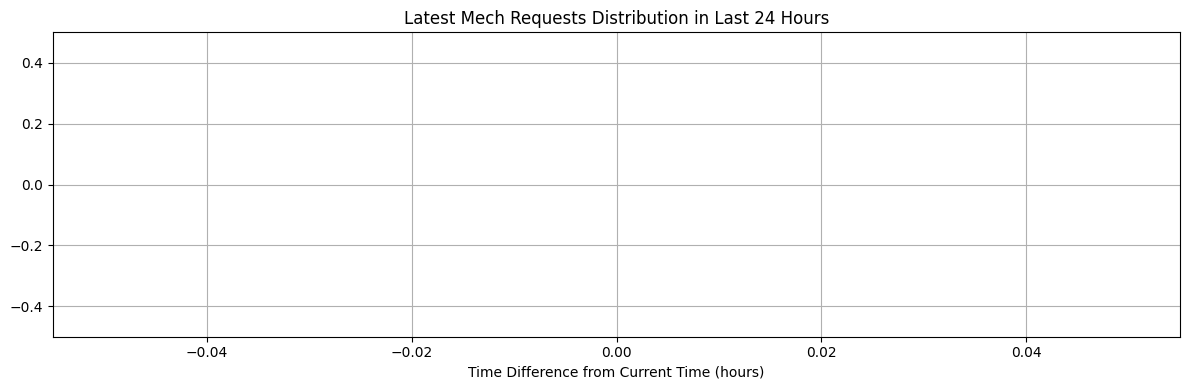

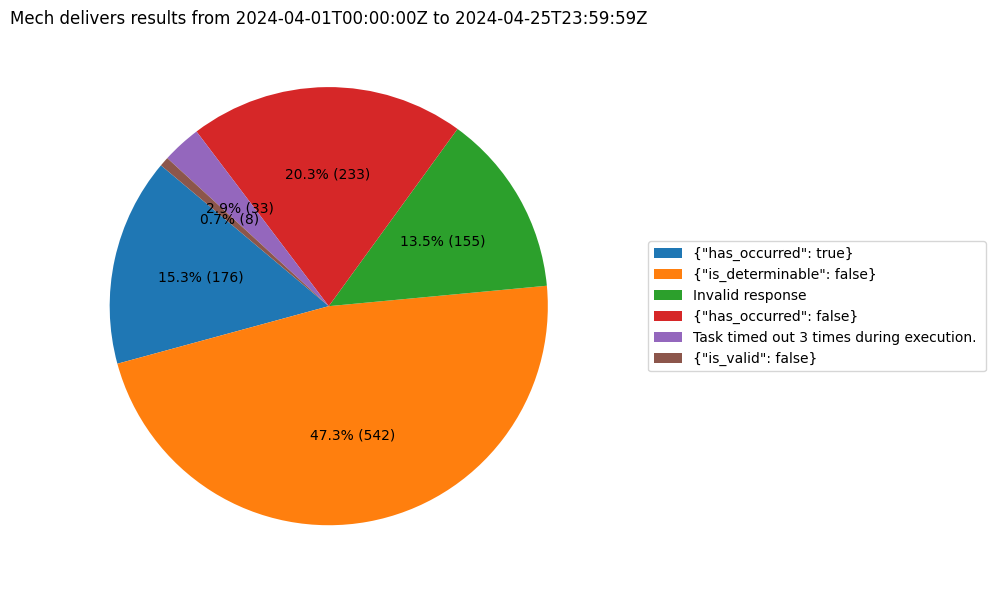

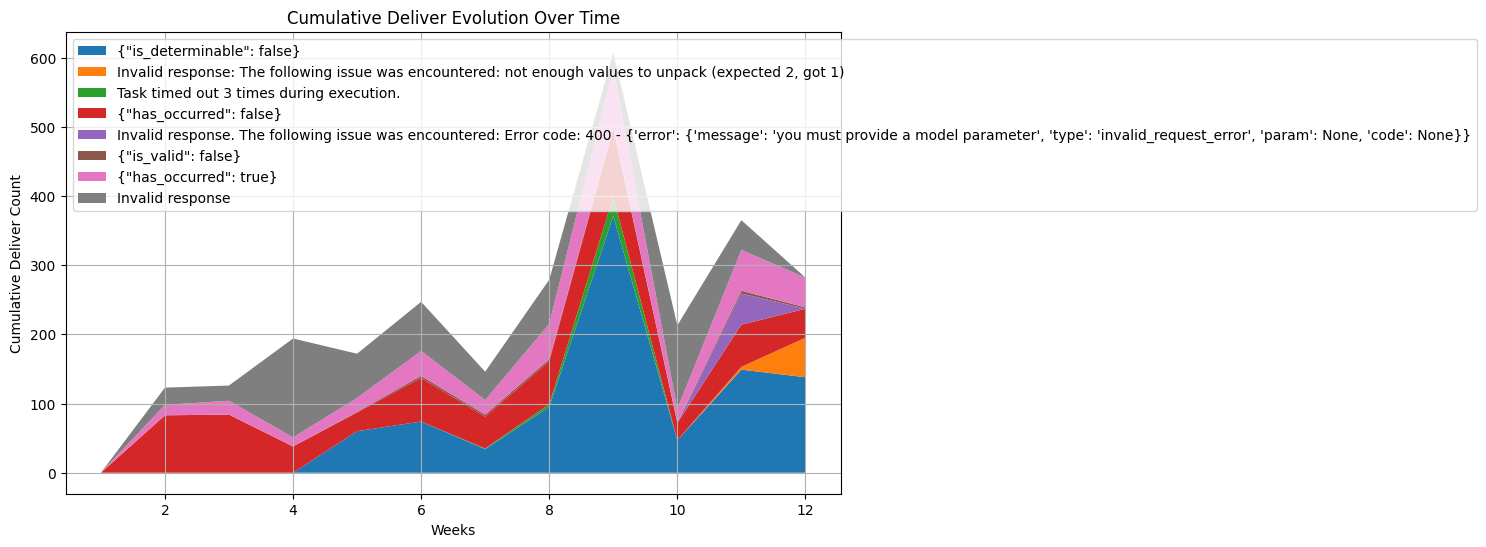

In [3]:
class MechDeliverState(Enum):
    """Market state"""

    INVALID_RESPONSE = 1
    TIMEOUT = 2
    RESP_NOT_DETERMINABLE = 3
    RESP_INVALID_MARKET = 4
    RESP_YES = 5
    RESP_NO = 6
    UNKNOWN = 7
    NA = 8

    def __str__(self) -> str:
        """Prints the market status."""
        return self.name.lower()

# HISTOGRAM OF BLOCK DELAYS
deliver_delay_blocks = []
for request_data in mech_requests.values():
    if 'deliver' in request_data:
        request_block = int(request_data['blockNumber'])
        deliver_block = int(request_data['deliver']['blockNumber'])
        delay = deliver_block - request_block
        deliver_delay_blocks.append(delay)

deliver_delay_blocks_stats = stats.describe(deliver_delay_blocks)
print(deliver_delay_blocks_stats)

# Filter out outliers
mean = deliver_delay_blocks_stats[2]
std = np.sqrt(deliver_delay_blocks_stats[3])
alpha = 5
deliver_delay_blocks = [td for td in deliver_delay_blocks if np.abs(td - mean) <= alpha * std]
#deliver_delay_blocks = [td for td in deliver_delay_blocks]


# Create histogram
plt.hist(deliver_delay_blocks, bins=100, color='blue', edgecolor='black')
plt.xlabel('Deliver delay (blocks)')
plt.ylabel('Frequency')
plt.title('Block delays between Delivers and Requests')
plt.grid(True)
plt.show()


# HISTOGRAM OF DELIVERS PER RESPONSE
def _count_delivers_type_per_response(mech_requests: Dict[str, Any], from_timestamp: int = 0, to_timestamp: int = 2147483647) -> None:
    result_counts = {}

    for request_data in mech_requests.values():
        block_timestamp = int(request_data.get('blockTimestamp', 0))
        if from_timestamp <= block_timestamp <= to_timestamp:
            if 'deliver' in request_data:
                result = request_data['deliver']['ipfsContents']['result']
                try:
                    result_json = json.loads(result)
                    first_item_key = list(result_json.keys())[0]
                    first_item_value = result_json[first_item_key]
                    result = json.dumps({first_item_key: first_item_value})
                    result_counts[result] = result_counts.get(result, 0) + 1
                except json.JSONDecodeError:
                    result_counts[result] = result_counts.get(result, 0) + 1
            else:
                result_counts[result] = result_counts.get(result, 0) + 1

    return result_counts


def plot_delivers_evolution_over_time(mech_requests: Dict[str, Any], from_timestamp: int, weeks: int = 1) -> None:
    all_result_counts = []

    for i in range(weeks):
        from_timestamp_week = from_timestamp + (i * 7 * 24 * 3600)  # Add i weeks
        to_timestamp_week = from_timestamp_week + (7 * 24 * 3600)  # One week later
        result_counts = _count_delivers_type_per_response(mech_requests, from_timestamp_week, to_timestamp_week)
        all_result_counts.append(result_counts)

    result_types = set().union(*(d.keys() for d in all_result_counts))
    result_counts_per_week = {result_type: [week_result_counts.get(result_type, 0) for week_result_counts in all_result_counts] for result_type in result_types}

    plt.figure(figsize=(10, 6))
    weeks_range = range(1, weeks + 1)
    cumulative_counts = [0] * weeks
    for result_type, counts_per_week in result_counts_per_week.items():
        plt.fill_between(weeks_range, cumulative_counts, [cumulative_count + current_count for cumulative_count, current_count in zip(cumulative_counts, counts_per_week)], label=result_type)
        cumulative_counts = [cumulative_count + current_count for cumulative_count, current_count in zip(cumulative_counts, counts_per_week)]

    plt.title('Cumulative Deliver Evolution Over Time')
    plt.xlabel('Weeks')
    plt.ylabel('Cumulative Deliver Count')
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()


def plot_latest_mech_requests_count(mech_requests: Dict[str, Any]) -> None:

    timestamps = [int(r["blockTimestamp"]) for r in mech_requests.values()]
    
    sorted_timestamps = sorted(timestamps, reverse=True)
    now = datetime.now().timestamp()
    last_24_hours = [ts for ts in timestamps if now - ts <= 4*60*60]

    x_coords = [(now - ts) / 3600 for ts in timestamps if now - ts <= 4*60*60]
    y_coord = 0  # y-coordinate for all points
    
    plt.figure(figsize=(12, 4))
    plt.scatter(x_coords, [y_coord] * len(x_coords), marker='o')
    plt.xlabel('Time Difference from Current Time (hours)')
    plt.title('Latest Mech Requests Distribution in Last 24 Hours')
    plt.ylim(-0.5, 0.5)  # Set y-axis limits to center the points
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def display_latest_requests(mech_requests: Dict[str, Any], N: int=20) -> None:
    sorted_requests = sorted(mech_requests.values(), key=lambda x: int(x['blockTimestamp']), reverse=True)[:N]

    data = {
        "Request ID": [],
        "Prompt": [],
        "Block Timestamp (UTC)": [],
        "Result": [],
        "Deliver Block Timestamp (UTC)": []
    }

    for request in sorted_requests:
        data["Request ID"].append(request['requestId'])
        data["Prompt"].append(request['ipfsContents']['prompt'])
        data["Block Timestamp (UTC)"].append(datetime.utcfromtimestamp(int(request['blockTimestamp'])))
        if 'deliver' in request:
            deliver = request['deliver']
            data["Result"].append(deliver['ipfsContents']['result'])
            data["Deliver Block Timestamp (UTC)"].append(datetime.utcfromtimestamp(int(deliver['blockTimestamp'])))
        else:
            data["Result"].append(None)
            data["Deliver Block Timestamp (UTC)"].append(None)

    df = pd.DataFrame(data)
    display(HTML(df.to_html()))

display_latest_requests(mech_requests)
plot_latest_mech_requests_count(mech_requests)

from_date = "2024-04-01T00:00:00Z"
to_date = "2024-04-25T23:59:59Z"

from_timestamp = int(dateutil.parser.isoparse(from_date).replace(tzinfo=pytz.utc).timestamp())
to_timestamp = int(dateutil.parser.isoparse(to_date).replace(tzinfo=pytz.utc).timestamp())

result_counts = _count_delivers_type_per_response(mech_requests, from_timestamp, to_timestamp)

# Calculate total count
total_count = sum(result_counts.values())

# Separate result types and counts
result_types = list(result_counts.keys())
counts = list(result_counts.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.title(f'Mech delivers results from {from_date} to {to_date}')
plt.axis('equal')
plt.pie(counts, labels=None, autopct=lambda pct: f'{pct:.1f}% ({int(np.round(pct / 100. * total_count))})', startangle=140)
plt.legend(result_types, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


from_date = "2024-02-19T00:00:00Z"
from_timestamp = int(dateutil.parser.isoparse(from_date).replace(tzinfo=pytz.utc).timestamp())

plot_delivers_evolution_over_time(mech_requests, from_timestamp, weeks=12)  # Plot evolution for 4 weeks


## Process Omen markets
Process Omen markets by reading from the Omen xDAI Subgraph

In [4]:
class MarketState(Enum):
    """Market state"""

    OPEN = 1
    PENDING = 2
    FINALIZING = 3
    ARBITRATING = 4
    CLOSED = 5
    UNKNOWN = 6

    def __str__(self) -> str:
        """Prints the market status."""
        return self.name.capitalize()


answer_mapping = defaultdict(
    lambda: "Unknown",
    {
        "0x0000000000000000000000000000000000000000000000000000000000000000": "Yes",
        "0x0000000000000000000000000000000000000000000000000000000000000001": "No",
        "0xffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff": "Invalid",
    },
)

headers = {
    "Accept": "application/json, multipart/mixed",
    "Content-Type": "application/json",
}

omen_xdai_fpmms_query = Template(
    """
    {
      fixedProductMarketMakers(
        where: {
          creator: "0x89c5cc945dd550bcffb72fe42bff002429f46fec",
          creationTimestamp_gt: "${creationTimestamp_gt}"
        }
        orderBy: creationTimestamp
        orderDirection: asc
        first: 1000
      ) {
        question {
          title
          outcomes
          currentAnswer
          currentAnswerTimestamp
          answers {
            answer
          }
        }
        id
        openingTimestamp
        resolutionTimestamp
        creationTimestamp
        isPendingArbitration
        answerFinalizedTimestamp
        currentAnswer
        collateralVolume
      }
    }
    """
)


def _get_date(timestamp: float) -> str:
    try:
        timestamp = int(timestamp)
        return datetime.utcfromtimestamp(timestamp).isoformat()
    except Exception:  # pylint: disable=broad-except
        return "--"


def _get_market_state(market: Dict[str, Any]) -> MarketState:
    try:
        now = datetime.utcnow()

        market_status = MarketState.CLOSED
        if market["currentAnswer"] is None and now >= datetime.utcfromtimestamp(float(market.get("openingTimestamp", 0))):
            market_status = MarketState.PENDING
        elif market["currentAnswer"] is None:
            market_status = MarketState.OPEN
        elif market["isPendingArbitration"]:
            market_status = MarketState.ARBITRATING
        elif now < datetime.utcfromtimestamp(float(market.get("answerFinalizedTimestamp", 0))):
            market_status = MarketState.FINALIZING

        return market_status
    except Exception:  # pylint: disable=broad-except
        return MarketState.UNKNOWN


def _get_remaining_resolution_time(market: Dict[str, Any]) -> str:
    if market["answerFinalizedTimestamp"]:
        now = datetime.utcnow()

        finalized_time = datetime.utcfromtimestamp(
            float(market["answerFinalizedTimestamp"])
        )
        time_diff = finalized_time - now

        if time_diff >= timedelta(0):
            hours = int(time_diff.total_seconds() // 3600)
            minutes = int((time_diff.total_seconds() % 3600) // 60)
            return "{:02d}:{:02d}".format(hours, minutes)
    return "--"


def _get_market_title(market: Dict[str, Any]) -> str:
    question_title = "question_title"
    url = ""
    if market.get("question"):
        question_title = market["question"].get("title", "")
        url = f'https://presagio.pages.dev/markets?id={market.get("id","")}'
    return _make_clickable(question_title, url)


def _get_collateral_volume(market: Dict[str, Any]) -> str:
    volume = int(market.get("collateralVolume", 0))
    formatted_volume = f"{volume / 10**18:.2f}"
    return formatted_volume

def _get_current_answer(market: Dict[str, Any]) -> str:
    currentAnswer = market.get("currentAnswer", "")
    if not currentAnswer:
        currentAnswer = ""
    return answer_mapping.get(currentAnswer.lower(), "--")


def _get_num_answers(market: Dict[str, Any]) -> int:
    question = market.get("question", {})
    if not question:
        question = {}
    return len(question.get("answers", []))


def _execute_fpmm_query() -> Dict[str, Any]:
    url = os.getenv('OMEN_SUBGRAPH_URL', 'https://api.thegraph.com/subgraphs/name/protofire/omen-xdai')

    all_markets = []
    creationTimestamp_gt = "0"

    while True:
        query = omen_xdai_fpmms_query.substitute(
            creationTimestamp_gt=creationTimestamp_gt,
        )
        content_json = {
            "query": query,
            "variables": None,
            "extensions": {"headers": None},
        }
        res = requests.post(url, headers=headers, json=content_json, timeout=300)
        result_json = res.json()
        markets = result_json.get("data", {}).get("fixedProductMarketMakers", [])

        if not markets:
            break

        all_markets.extend(markets)
        creationTimestamp_gt = markets[len(markets) - 1]["creationTimestamp"]

    output = {"data": {"fixedProductMarketMakers": all_markets}}
    return output

def _make_clickable(text: str, url: str, tooltip: Optional[str]=None) -> str:
    if tooltip:
        return f'<a href="{url}" title="{tooltip}" target="_blank">{text}</a>'
    return f'<a href="{url}" target="_blank">{text}</a>'



In [5]:
def _populate_with_mech_requests(data: Dict[str, Any], mech_requests: Dict[str, Any]) -> None:
    """Populates the markets by appending an array of the associated mech requests"""
    markets = data["data"]["fixedProductMarketMakers"]
    markets_dict = {market["question"].get("title", ""): market for market in markets if market.get("question")}

    for mech_request in mech_requests.values():
        if "ipfsContents" in mech_request:
            q = mech_request["ipfsContents"]["prompt"]
            if q in markets_dict:
                markets_dict[q].setdefault("mechRequests", []).append(mech_request)
            else:
                print("Market not found for mech request: {mech_request}")
    
    for market in markets:
        market.setdefault("mechRequests", []).sort(key=lambda x: x.get("blockNumber", 0), reverse=True)

def _get_last_mech_deliver_link(market: Dict[str, Any], latest: Optional[int]=None) -> str:
    if market["mechRequests"]:
        output = ""
        n = len(market["mechRequests"])
        if not latest:
            latest = n
        for i in range(min(latest, n)):
            request = market["mechRequests"][i]
            if "deliver" in request:
                deliver = request["deliver"]
                ipfs_hash = deliver.get("ipfsHash", "")
                request_id = deliver.get("requestId", "")
                url = f"{IPFS_ADDRESS}{ipfs_hash}/{request_id}"
                output += _make_clickable(f"[{n-i}]", url, _get_date(deliver["blockTimestamp"]))
            else:
                output += "[X]"
            output += " "
        
        return output
    
    return "-"

def _get_num_mech_requests(market: Dict[str, Any]) -> int:
    if market["mechRequests"]:
        return len(market["mechRequests"])
    return 0


def _get_last_mech_deliver_state(market: Dict[str, Any]) -> str:
    if not market["mechRequests"]:
        return MechDeliverState.NA

    request = market["mechRequests"][0]
    if "deliver" not in request:
        return  MechDeliverState.UNKNOWN

    result = request["deliver"]["ipfsContents"]["result"]
    
    if result == "Invalid response":
        return MechDeliverState.INVALID_RESPONSE
    if result.startswith("Task timed out"):
        return MechDeliverState.TIMEOUT

    result = result.replace(" ", "")
    if "is_determinable\":false" in result:
        return MechDeliverState.RESP_NOT_DETERMINABLE
    if "\"has_occurred\":false" in result:
        return MechDeliverState.RESP_NO
    if "\"has_occurred\":true" in result:
        return MechDeliverState.RESP_YES
    if "\"is_valid\":false" in result:
        return MechDeliverState.RESP_INVALID_MARKET

    return MechDeliverState.UNKNOWN


def _get_mech_deliver_delay(market: Dict[str, Any]) -> int:
    if not market["mechRequests"]:
        return -1

    request = market["mechRequests"][0]
    if "deliver" not in request:
        return  -1

    deliver = request["deliver"]

    return int(deliver["blockTimestamp"]) - int(request["blockTimestamp"])

def _generate_markets_df(data, mech_requests) -> pd.DataFrame:
    _populate_with_mech_requests(data, mech_requests)
    rows = []
    for entry in data["data"]["fixedProductMarketMakers"]:
        rows.append(
            {
                "Title": _get_market_title(entry),
                "Volume (xDAI):": _get_collateral_volume(entry),
                "Current answer": _get_current_answer(entry),
                "Num answers": _get_num_answers(entry),
                "State": _get_market_state(entry),
                "Remaining time to challenge (hh:mm)": _get_remaining_resolution_time(entry),
                "Creation (UTC)": _get_date(entry["creationTimestamp"]),
                "Opening (UTC)": _get_date(entry["openingTimestamp"]),
                "Answer finalized (UTC)": _get_date(entry["answerFinalizedTimestamp"]),
                "Resolution (UTC)": _get_date(entry["resolutionTimestamp"]),
                "Num. mech requests": _get_num_mech_requests(entry),
                "Mech delivers": _get_last_mech_deliver_link(entry),
                "Deliver delay": _get_mech_deliver_delay(entry),
                "Mech deliver state": _get_last_mech_deliver_state(entry)
            }
        )

    df = pd.DataFrame(rows)
    df['State'] = df['State'].astype('category')
    df['Mech deliver state'] = df['Mech deliver state'].astype('category')
    df.sort_values(by="Creation (UTC)", ascending=True, inplace=True)
    return df

data = _execute_fpmm_query()
df = _generate_markets_df(data, mech_requests)
df.style.set_properties(subset=["Title"], **{'text-align': 'right'})
print("")

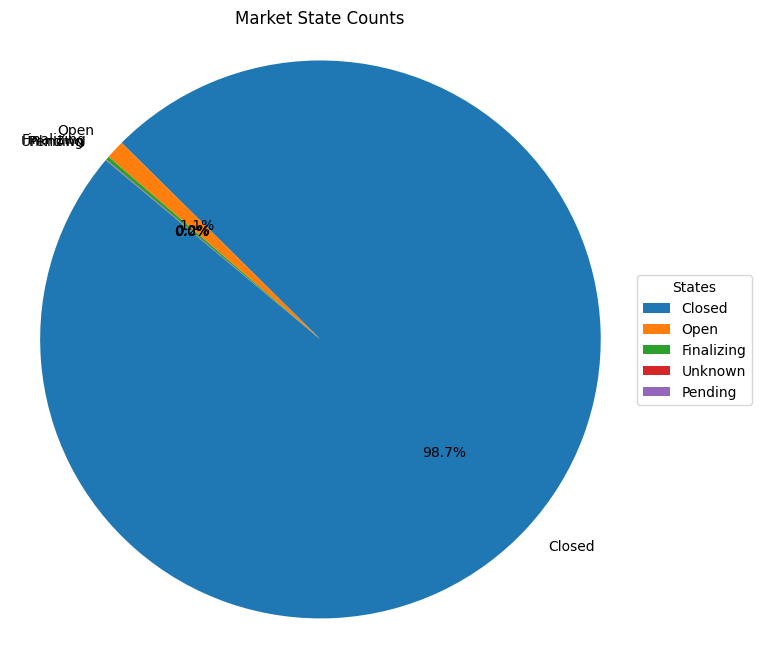

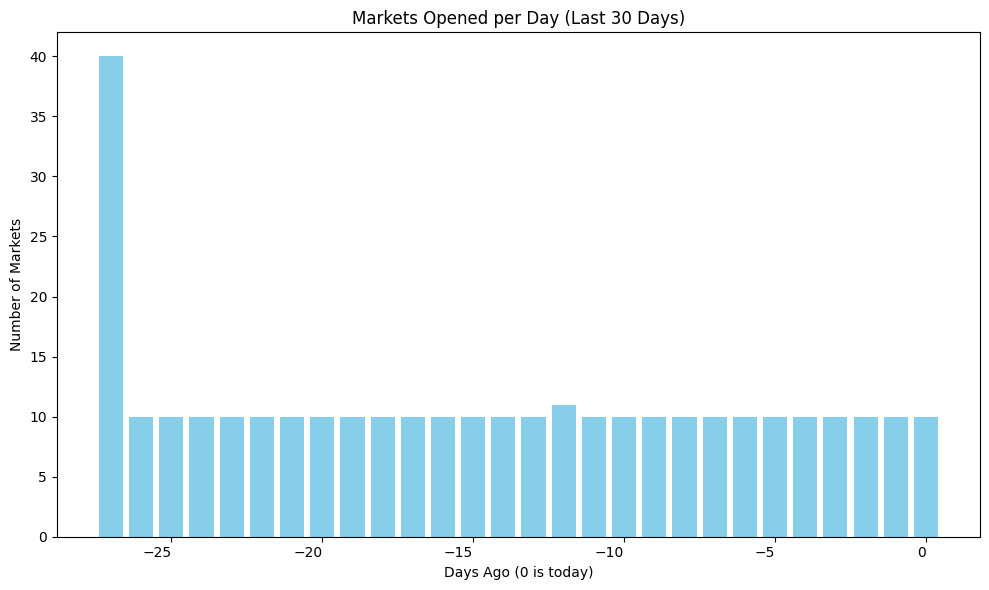


Mech requests per state:
State
Unknown          0
Closed        5575
Open             0
Finalizing      10
Pending          0
Name: Num. mech requests, dtype: int64


/tmp/ipykernel_304874/625254711.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('State')['Num. mech requests'].sum())


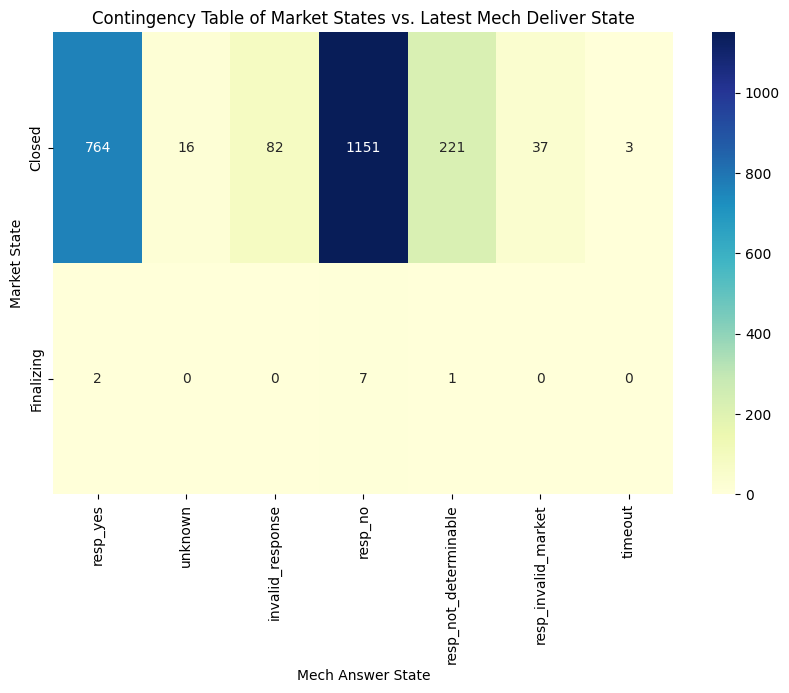

Filtering [<MarketState.PENDING: 2>, <MarketState.FINALIZING: 3>] markets


,Title,Volume (xDAI):,Current answer,Num answers,State,Remaining time to challenge (hh:mm),Creation (UTC),Opening (UTC),Answer finalized (UTC),Resolution (UTC),Num. mech requests,Mech delivers,Deliver delay,Mech deliver state
4707,Will Linkin Park's first tour since Chester Bennington's death with new female singer be successful?,12.95,Invalid,1,Finalizing,01:09,2024-09-09T02:13:10,2024-09-14T00:00:00,2024-09-16T19:03:00,--,1,[1],65,resp_not_determinable
4723,Will the trial of the three ex-officers over Tyre Nichols' fatal assault conclude by 15 September 2024?,42.19,No,1,Finalizing,08:44,2024-09-11T00:04:20,2024-09-16T00:00:00,2024-09-17T02:38:35,--,1,[1],95,resp_no
4724,Will the Michigan vs. Texas college football game result in a Michigan victory on 15 September 2024?,46.76,No,1,Finalizing,07:10,2024-09-11T00:20:30,2024-09-16T00:00:00,2024-09-17T01:04:40,--,1,[1],140,resp_no
4725,Will the Apple Pay system introduce a major change in its service by 15th September 2024?,27.31,--,0,Pending,--,2024-09-11T00:35:15,2024-09-16T00:00:00,--,--,0,-,--,na
4726,Will Tom Brady start his NFL broadcasting career on 15 September 2024?,28.81,No,1,Finalizing,07:56,2024-09-11T00:51:55,2024-09-16T00:00:00,2024-09-17T01:50:10,--,1,[1],85,resp_no
4727,Will Apple launch the iPhone 16 by 15 September 2024?,72.31,Yes,1,Finalizing,06:54,2024-09-11T01:06:10,2024-09-16T00:00:00,2024-09-17T00:48:25,--,1,[1],105,resp_yes
4728,Will England batsman Ben Duckett play against Sri Lanka in the third Test on 15 September 2024?,22.39,Yes,1,Finalizing,06:39,2024-09-11T01:20:30,2024-09-16T00:00:00,2024-09-17T00:33:10,--,1,[1],105,resp_yes
4729,Will Nanoleaf launch another smart switch on or by 15 September 2024?,139.06,Yes,2,Finalizing,06:40,2024-09-11T02:09:10,2024-09-16T00:00:00,2024-09-17T00:34:25,--,1,[1],125,resp_no
4730,Will Tropical Storm Francine hit Louisiana as a hurricane on 15 September 2024?,28.57,No,1,Finalizing,06:39,2024-09-11T02:23:35,2024-09-16T00:00:00,2024-09-17T00:33:45,--,1,[1],75,resp_no
4731,"Will the Greece's new tax on cruise ship arrivals be successfully implemented by September 15, 2024?",8.60,No,1,Finalizing,08:30,2024-09-11T02:37:00,2024-09-16T00:00:00,2024-09-17T02:24:30,--,1,[1],65,resp_no


In [6]:

def plot_opened_markets(data: Dict[str, Any]) -> None:

    markets = data["data"]["fixedProductMarketMakers"]
    current_utc_timestamp = datetime.utcnow().replace(hour=0, minute=0, second=0, microsecond=0)
    
    day_counts = {}

    for item in markets:
        if item['creationTimestamp'] is not None:
            creation_timestamp = int(item['creationTimestamp'])
            creation_datetime = datetime.utcfromtimestamp(creation_timestamp)
            
            days_diff = (creation_datetime - current_utc_timestamp).days

            if -days_diff <= 30:
                day_counts[days_diff] = day_counts.get(days_diff, 0) + 1

    sorted_counts = dict(sorted(day_counts.items()))

    days = list(sorted_counts.keys())
    counts = list(sorted_counts.values())

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.bar(days, counts, width=0.8, color='skyblue')
    plt.title('Markets Opened per Day (Last 30 Days)')
    plt.xlabel('Days Ago (0 is today)')
    plt.ylabel('Number of Markets')
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()
    plt.show()


def plot_market_state_count(df: pd.DataFrame) -> None:
    state_counts = df["State"].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(state_counts, labels=state_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Market State Counts')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Display legend next to the pie chart
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="States", fancybox=True)

    plt.show()


def format_seconds(seconds: int) -> str:
    if seconds < 0:
        return "--"
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    #seconds = seconds % 60
    #return f"{int(hours):02}h {int(minutes):02}m {int(seconds):02}s"
    return str(seconds)

plot_market_state_count(df)
plot_opened_markets(data)




print("\nMech requests per state:")
print(df.groupby('State')['Num. mech requests'].sum())



filtered_df = df[df['Mech deliver state'] != MechDeliverState.NA]

# Generate the contingency table
contingency_table = pd.crosstab(filtered_df['State'], filtered_df['Mech deliver state'])

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Contingency Table of Market States vs. Latest Mech Deliver State')
plt.xlabel('Mech Answer State')
plt.ylabel('Market State')
plt.show()



# Select markets to display
market_states = [
    #MarketState.OPEN,
    MarketState.PENDING,
    MarketState.FINALIZING,
    #MarketState.ARBITRATING,
    #MarketState.CLOSED,
    #MarketState.UNKNOWN
]

print(f"Filtering {market_states} markets")
df_filtered = df[df["State"].isin(market_states)]
#df_filtered = df[df["Current answer"]=="Invalid"]


pd.options.display.max_colwidth = 150
html = df_filtered.to_html(
    escape=False,
    classes='sortable',
    formatters={'Deliver delay': format_seconds}
    )

display(HTML(html))

In [7]:
def plot_closed_markets(data: Dict[str, Any], start_timestamp: int, end_timestamp: int) -> None:
    markets = data["data"]["fixedProductMarketMakers"]
    
    filtered_markets = [
        item for item in markets
        if item['creationTimestamp'] is not None and
        start_timestamp <= int(item['creationTimestamp']) < end_timestamp
    ]
    
    print(len(filtered_markets))
    answer_counts = {}

    for item in filtered_markets:
        current_answer = item.get('currentAnswer')
        
        if current_answer is not None:
            answer_counts[current_answer] = answer_counts.get(current_answer, 0) + 1
            
            # Collect the questions for filtered markets
            question = item.get('question', {}).get('title', 'No Title')

    # Prepare data for pie chart
    labels = [f"{answer_mapping.get(answer.lower(), '--')} ({count})" for answer, count in answer_counts.items()]
    sizes = list(answer_counts.values())

    # Format the dates for the title
    start_datetime = datetime.fromtimestamp(start_timestamp, tz=timezone.utc)
    end_datetime = datetime.fromtimestamp(end_timestamp, tz=timezone.utc)
    start_date_str = start_datetime.isoformat()
    end_date_str = end_datetime.isoformat()

    # Plot pie chart
    plt.figure(figsize=(10, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    plt.title(f'Distribution of Current Answers in Closed Markets\nCreation timestamp: >= {start_date_str} UTC < {end_date_str} UTC')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

    for item in filtered_markets:
        if item.get('currentAnswer') == "0xffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff":
            print(f'- {item["question"].get("title", "")}')



# month= 7
plot_closed_markets(data, int(datetime(2024, 6, 1, tzinfo=timezone.utc).timestamp()), int(datetime(2024, month+1, 31, tzinfo=timezone.utc).timestamp()))




NameError: name 'timezone' is not defined